## 期末專案：**針對釣魚信件**之情緒分析（Lexicon)
Last modified: 陳文薇（2024/05/29）<br>


#### 大綱
1. 載入套件說明
2. 資料前處理、詞頻
3. 只針對釣魚信件lexicon-base 情緒分析
  + 3.1 準備LIWC情緒字典
  + 3.2 情緒字典與斷詞結果進行合併
  + 3.3 正負向情緒分數聲量長條圖
  + 3.4 正負向情緒分數聲量密度圖
  + 3.5 正負向情緒分數比例箱型圖
  + 3.6 正負向情緒分數聲量長條圖(去除離群值與離群值用平均替代)
  + 3.7 文字雲
    + 第14275封之文字雲
  + 3.6 情緒代表字
    + 第14275封之正負相情緒代表字
  + 3.7 各封情緒分數

## <font color=#ffa>套件載入</font>

In [1]:
!pip install plotly
!pip install seaborn

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
# 載入套件
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import seaborn as sns

from wordcloud import WordCloud # pip install wordcloud
import matplotlib.pyplot as plt

# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']

Duplicate key in file '/Users/chenwenwei/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc' line #749.
Duplicate key in file '/Users/chenwenwei/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc' line #750.
Duplicate key in file '/Users/chenwenwei/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc' line #751.


In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chenwenwei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### <font color=#ffa>--------資料前處理開始--------
用 nltk 套件做斷句、斷詞、stemming
資料集：18650封信件
資料來源：https://www.kaggle.com/datasets/subhajournal/phishingemails/data
</font>

In [4]:
maildata = pd.read_csv("./dataset/Phishing_Email.csv")
df = maildata
print(df.shape)

(18650, 3)


In [5]:
# 斷句
maildata = maildata.assign(sentence = maildata['Email Text'].astype(str).apply(nltk.sent_tokenize)).explode('sentence').reset_index(drop=True)

# 刪除標點符號/數字/換行符號
maildata["sentence"] = maildata["sentence"].apply(lambda x: re.sub(r'[^\w\s]','', str(x)))  #只留下英文字母和空格(包含換行符號)
maildata['sentence'] = maildata["sentence"].str.replace(r'[\d]+', '', regex=True).astype(str) #去除數字
maildata["sentence"] = maildata["sentence"].apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格


# 去除空值
# dataset 有些郵件是 empty
# 經過 nltk 套件會有些東西變 nan
maildata = maildata[maildata["sentence"] != "empty"]
maildata = maildata[maildata["sentence"] != "nan"]

# 斷詞
token_df = maildata.assign(token = maildata['sentence'].apply(nltk.word_tokenize)).explode('token').reset_index(drop=True)

# 轉成小寫
lowerWord_df = token_df.assign(word = token_df['token'].str.lower())

In [6]:
# stemming
# porter = PorterStemmer()
# mails_df = lowerWord_df.assign(stem_token = lowerWord_df['word'].astype(str).apply(porter.stem)).reset_index(drop=True)

# lemmatization
lm = WordNetLemmatizer()
mails_df = lowerWord_df.assign(stem_token = lowerWord_df['word'].astype(str).apply(lm.lemmatize)).reset_index(drop=True)


In [7]:
# 將不必要的欄位 以及 nan 刪掉
tidy_mails_df = mails_df.drop(columns=["token", "word"])
tidy_mails_df = tidy_mails_df.rename(columns={"Unnamed: 0":"index", "stem_token":"word"})
tidy_mails_df = tidy_mails_df[tidy_mails_df['word'] != 'nan']

In [8]:
def is_single_english_letter(word):
    # 使用正則表達式匹配僅包含一個英文字母的字符串
    #return bool(re.fullmatch(r'[a-zA-Z]', word))
    return len(word) <= 1

tidy_mails_df = tidy_mails_df[~tidy_mails_df['word'].apply(is_single_english_letter)]

In [9]:
tidy_mails_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6836675 entries, 0 to 7318687
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   index       int64 
 1   Email Text  object
 2   Email Type  object
 3   sentence    object
 4   word        object
dtypes: int64(1), object(4)
memory usage: 313.0+ MB


In [10]:
tidy_mails_df.head(5)

,index,Email Text,Email Type,sentence,word
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,re,re
1,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,disc
2,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,uniformitarianism
3,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,re
4,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,sex


### 移除停用字

In [11]:
# 初次使用需要安裝nltk中的停用字資源
nltk.download('stopwords')
# 使用nltk的stop_words
stops = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chenwenwei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# 手動加入停用字
newStops = ['email','com','wa','ect','one','would','could','may','can','de','also','edu','ha']
stops.extend(newStops)

In [13]:
noStop_df = tidy_mails_df[~tidy_mails_df['word'].isin(stops)]
noStop_df

,index,Email Text,Email Type,sentence,word
1,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,disc
2,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,uniformitarianism
4,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,sex
5,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,lang
6,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,disc uniformitarianism re sex lang dic...,dick
...,...,...,...,...,...
7318683,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,team
7318684,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,kind
7318685,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,regard
7318686,18649,press clippings - letter on californian utilit...,Safe Email,press clippings letter on californian utiliti...,kuldeep


### <font color=#ffa>--------資料前處理結束--------
</font>

## 計算詞頻
下面分為全部字的詞頻、Phishing mail詞頻、Safe mail詞頻

### 總信件字詞頻（刪除停用字後）

In [14]:
freq_noStop_df = pd.DataFrame(noStop_df['word'].value_counts()).reset_index()
freq_noStop_df.columns = ['word', 'freq']
freq_noStop_df.head(30)

,word,freq
0,language,23428
1,enron,19274
2,university,17510
3,information,14703
4,please,13774
5,new,13373
6,subject,12514
7,time,11610
8,company,11540
9,address,11488


freq_noStop_df.iloc[:15].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

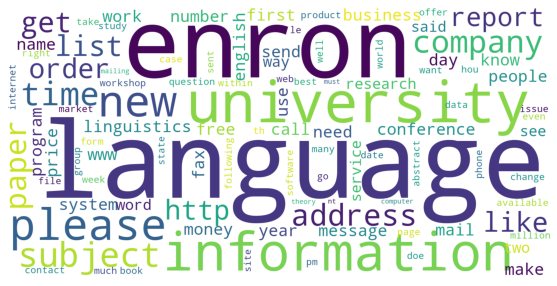

In [15]:
text = freq_noStop_df.set_index('word').to_dict()
wordcloud = WordCloud(scale = 4, background_color = 'white', max_words=100).generate_from_frequencies(text['freq'])
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

從總信件的詞頻長條圖與文字雲可看出：<br>
1. enron這家公司很常被提到，可能是與安隆事件相關（當年安隆事件的電子郵件至今仍大量散佈在網路上）<br>
2. language也很常出現，可能是因為幾乎每封電子郵件中的廣告都能讓使用者設定語言<br>

接下來會看phishing與safe信件的差異

### Phishing mail 詞頻

In [16]:
final_phishing = noStop_df[noStop_df['Email Type'] == 'Phishing Email']

In [17]:
freq_phishing = pd.DataFrame(final_phishing['word'].value_counts()).reset_index()
freq_phishing.columns = ['word', 'freq']
freq_phishing.head(30)

,word,freq
0,company,5117
1,free,4331
2,get,3985
3,report,3899
4,business,3848
5,please,3844
6,information,3842
7,money,3789
8,order,3687
9,address,3640


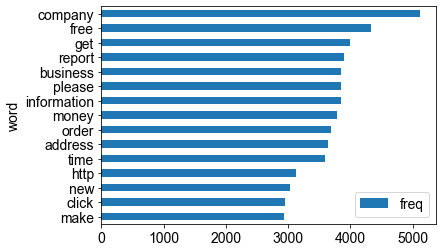

In [18]:
freq_phishing.iloc[:15].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

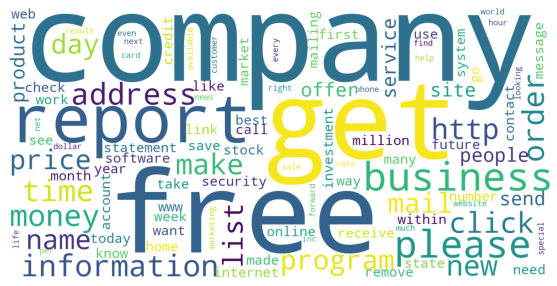

In [19]:
text = freq_phishing.set_index('word').to_dict()
wordcloud = WordCloud(scale = 4, background_color = 'white', max_words=100).generate_from_frequencies(text['freq'])
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

從phishing信件的詞頻長條圖與文字雲可看出：<br>
1. company很常被提到，可能是部分釣魚信件會偽裝成公司發出<br>
2. free、get、click、money出現頻率很高，推測釣魚信件中經常與金錢有關，且會請使用者點擊連結<br>


### Safe mail 詞頻

In [20]:
final_safe = noStop_df[noStop_df['Email Type'] == 'Safe Email']

In [21]:
freq_safe = pd.DataFrame(final_safe['word'].value_counts()).reset_index()
freq_safe.columns = ['word', 'freq']
freq_safe.head(30)

,word,freq
0,language,23332
1,enron,19271
2,university,17404
3,subject,11429
4,paper,10974
5,information,10861
6,new,10345
7,please,9930
8,linguistics,8908
9,conference,8406


freq_safe.iloc[:15].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

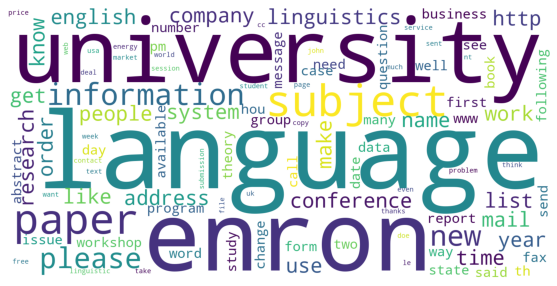

In [22]:
text = freq_safe.set_index('word').to_dict()
wordcloud = WordCloud(scale = 4, background_color = 'white', max_words=100).generate_from_frequencies(text['freq'])
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

從safe信件的詞頻長條圖與文字雲可看出，基本上phishing信件的高頻詞彙在safe信件中都不常出現，因此推測可用phishing信件的詞頻與文字雲來當作過濾釣魚信件的依據。

## 釣魚信件種類情緒分析開始

In [23]:
# 讀取情緒字典
en_dict_path = "./dict/liwc/LIWC_EN.csv"
liwc_dict = pd.read_csv(en_dict_path)
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})

In [24]:
our_liwc_df = pd.merge(final_phishing, liwc_dict, how="left")
our_liwc_df.head(3)

,index,Email Text,Email Type,sentence,word,sentiments
0,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,Hello I am your hot lil horny toy,hello,NaN
1,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,Hello I am your hot lil horny toy,hot,NaN
2,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,Hello I am your hot lil horny toy,lil,NaN


計算每封信件的情緒總和

In [25]:
our_liwc_df['sentiments'] = our_liwc_df['sentiments'].fillna('NaN')
# 使用 groupby 來計算每個 index 和 sentiment 的大小
sentiment_count = our_liwc_df.groupby(['index', 'sentiments']).size().reset_index(name='size')
# 將特殊值還原為 NaN
sentiment_count['sentiments'] = sentiment_count['sentiments'].replace('<NA>', 'NaN')
sentiment_count = sentiment_count.rename(columns={0: 'size'})

sentiment_count

,index,sentiments,size
0,3,NaN,36
1,3,affect,7
2,3,positive,7
3,4,NaN,52
4,4,affect,6
...,...,...,...
27340,18646,NaN,19
27341,18646,affect,5
27342,18646,negative,3
27343,18646,positive,1


### 正負向情緒分數聲量長條
分別畫出信件中，正向（positive）與負向（negative）情緒的折線圖

In [26]:
#合併
pos_tmp = sentiment_count[sentiment_count['sentiments']=='positive']
neg_tmp = sentiment_count[sentiment_count['sentiments']=='negative']
df_tmp = pd.merge(pos_tmp, neg_tmp, on="index", how="outer", suffixes=('_pos', '_neg'))
#以下為了讓列數一致，否則下面的圖會跑錯
pos = df_tmp[['index', 'sentiments_pos', 'size_pos']].fillna({'sentiments_pos': 'positive', 'size_pos': 0})
pos.rename(columns={'sentiments_pos': 'sentiments', 'size_pos': 'size'}, inplace=True)
neg = df_tmp[['index', 'sentiments_neg', 'size_neg']].fillna({'sentiments_neg': 'negative', 'size_neg': 0})
neg.rename(columns={'sentiments_neg': 'sentiments', 'size_neg': 'size'}, inplace=True)

In [27]:
print(pos.sort_values(by='size',ascending=False))
print('pos size has the avg :',pos['size'].mean())
print(neg.sort_values(by='size',ascending=False))
print('neg size has the avg :',neg['size'].mean())

      index sentiments   size
4615  14275   positive  310.0
4463  13765   positive  166.0
2101   6427   positive  162.0
1678   5133   positive  146.0
5474  16925   positive  142.0
...     ...        ...    ...
6108   7351   positive    0.0
6109   7465   positive    0.0
6110   7660   positive    0.0
6111   7713   positive    0.0
6276  18579   positive    0.0

[6277 rows x 3 columns]
pos size has the avg : 7.496734108650629
      index sentiments  size
2101   6427   negative  81.0
4615  14275   negative  76.0
4463  13765   negative  76.0
2880   8798   negative  35.0
4601  14224   negative  34.0
...     ...        ...   ...
1966   6003   negative   0.0
1959   5986   negative   0.0
1958   5984   negative   0.0
4292  13241   negative   0.0
0         3   negative   0.0

[6277 rows x 3 columns]
neg size has the avg : 1.763422016887048


這裡的結果顯示有過大的離群值導致圖繪製效果不佳

### 密度圖

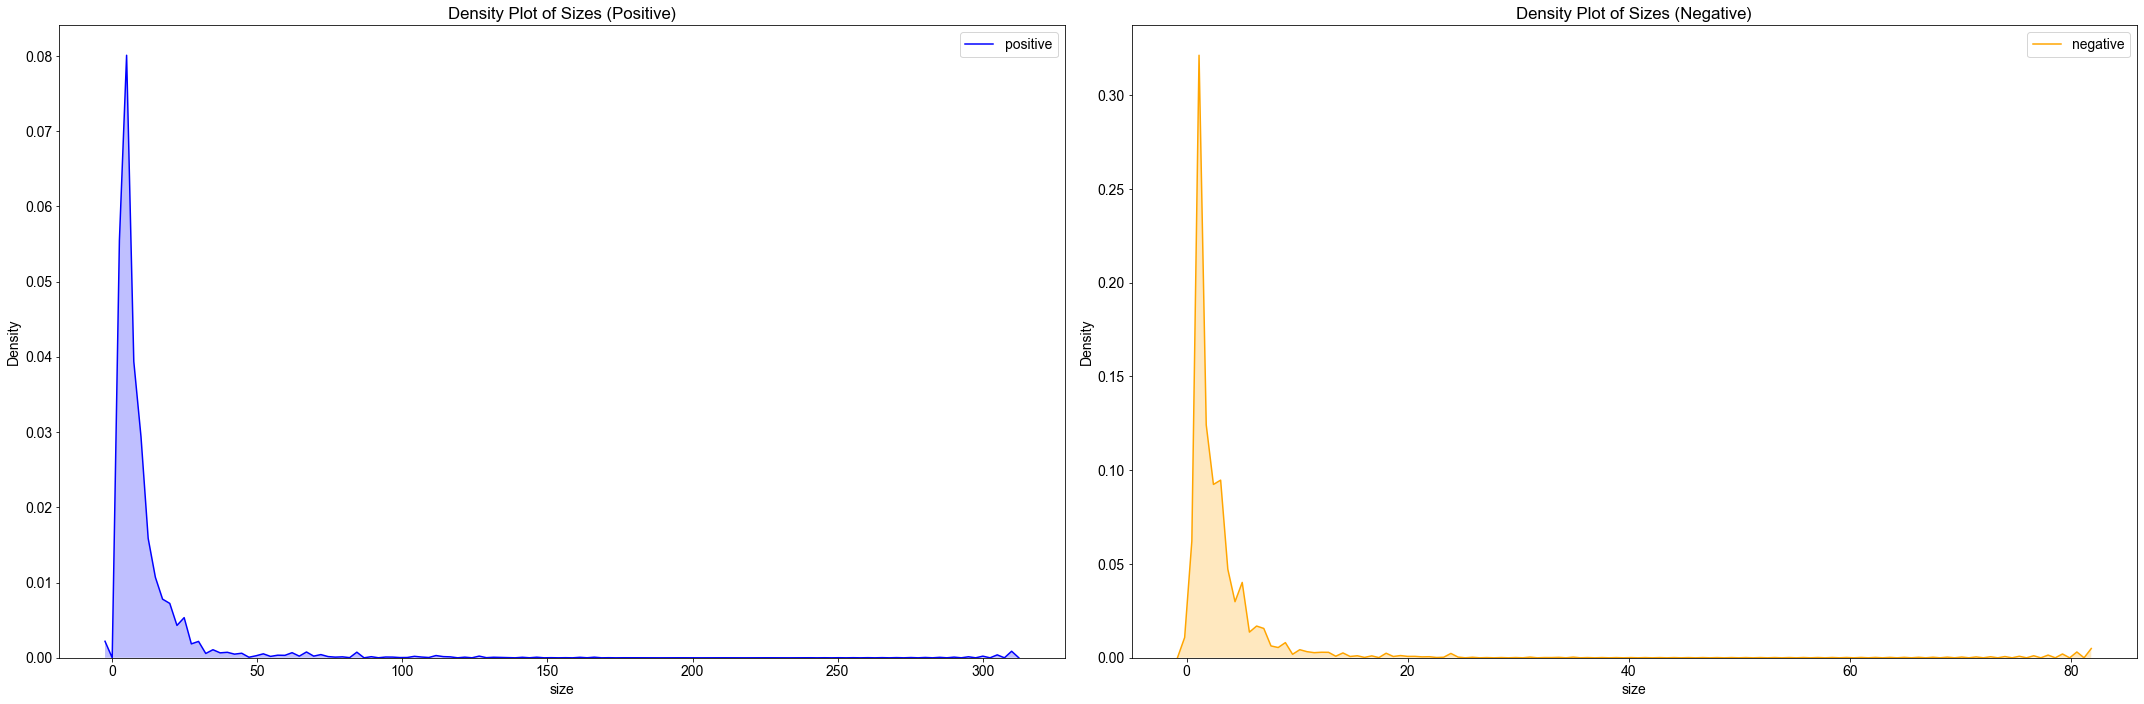

In [28]:
# 創建子圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

# 繪製第一個密度圖（pos）
sns.kdeplot(pos['size'], color="blue", shade=True, label="positive", ax=ax1)
ax1.set_xlabel('size')
ax1.set_ylabel('Density')
ax1.set_title('Density Plot of Sizes (Positive)')
ax1.legend()

# 繪製第二個密度圖（neg）
sns.kdeplot(neg['size'], color="orange", shade=True, label="negative", ax=ax2)
ax2.set_xlabel('size')
ax2.set_ylabel('Density')
ax2.set_title('Density Plot of Sizes (Negative)')
ax2.legend()

# 調整佈局
plt.tight_layout()
plt.show()

### 箱形圖(去除離群值)

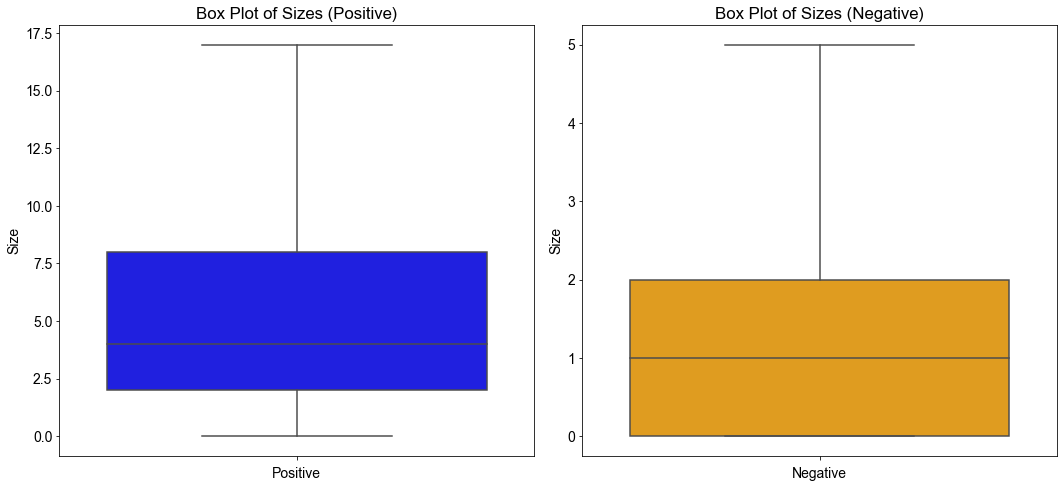

In [29]:
# 創建子圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# 繪製第一個箱型圖（pos）
sns.boxplot(y=pos['size'], ax=ax1, color="blue", showfliers=False)
ax1.set_xlabel('Positive')
ax1.set_ylabel('Size')
ax1.set_title('Box Plot of Sizes (Positive)')

# 繪製第二個箱型圖（neg）
sns.boxplot(y=neg['size'], ax=ax2, color="orange", showfliers=False)
ax2.set_xlabel('Negative')
ax2.set_ylabel('Size')
ax2.set_title('Box Plot of Sizes (Negative)')

# 調整佈局
plt.tight_layout()
plt.show()

結果顯示情緒稍微偏正向

### 長條堆疊圖（去除離群值）

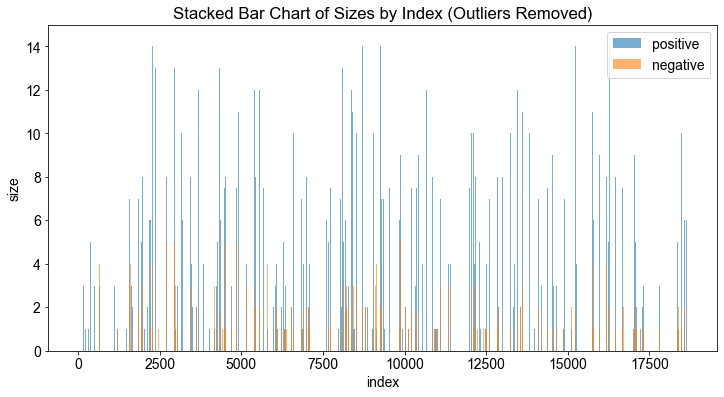

In [31]:
# 計算四分位數和四分位距
Q1_pos = pos['size'].quantile(0.25)
Q3_pos = pos['size'].quantile(0.75)
IQR_pos = Q3_pos - Q1_pos

Q1_neg = neg['size'].quantile(0.25)
Q3_neg = neg['size'].quantile(0.75)
IQR_neg = Q3_neg - Q1_neg

# 定義範圍
lower_bound_pos = Q1_pos - 1.5 * IQR_pos
upper_bound_pos = Q3_pos + 1.5 * IQR_pos

lower_bound_neg = Q1_neg - 1.5 * IQR_neg
upper_bound_neg = Q3_neg + 1.5 * IQR_neg

# 去除離群值
pos_filtered = pos[(pos['size'] >= lower_bound_pos) & (pos['size'] <= upper_bound_pos)]
neg_filtered = neg[(neg['size'] >= lower_bound_neg) & (neg['size'] <= upper_bound_neg)]

# 繪製堆疊條形圖
colors = ["tab:blue", "tab:orange"]
fig, ax = plt.subplots(figsize=(12, 6))

# 獲取最大值來設置 y 軸範圍
max_value = max(pos_filtered['size'].max(), neg_filtered['size'].max())
ax.set_ylim(0, max_value)

# 繪製條形圖
ax.bar(pos_filtered['index'], pos_filtered['size'], color=colors[0], alpha=0.6, align='center', label='positive')
ax.bar(neg_filtered['index'], neg_filtered['size'], color=colors[1], alpha=0.6, align='center', label='negative')

plt.xlabel('index')
plt.ylabel('size')
ax.legend(loc='upper right')
plt.title('Stacked Bar Chart of Sizes by Index (Outliers Removed)')
plt.show()

In [49]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("index")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,index,sentiments,size,ratio
0,3,NaN,36,0.720000
1,3,affect,7,0.140000
2,3,positive,7,0.140000
3,4,NaN,52,0.776119
4,4,affect,6,0.089552
...,...,...,...,...
27340,18646,NaN,19,0.612903
27341,18646,affect,5,0.161290
27342,18646,negative,3,0.096774
27343,18646,positive,1,0.032258


In [52]:
pos = sentiment_count[sentiment_count['sentiments'] == 'positive']
neg = sentiment_count[sentiment_count['sentiments'] == 'negative']

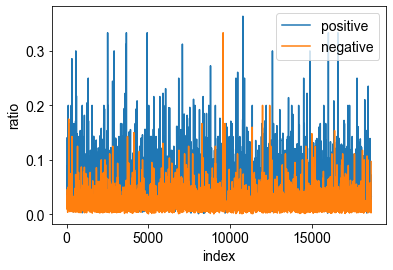

In [53]:
# 計算四分位數和四分位距
Q1_pos = pos['ratio'].quantile(0.25)
Q3_pos = pos['ratio'].quantile(0.75)
IQR_pos = Q3_pos - Q1_pos

Q1_neg = neg['ratio'].quantile(0.25)
Q3_neg = neg['ratio'].quantile(0.75)
IQR_neg = Q3_neg - Q1_neg

# 定義範圍
lower_bound_pos = Q1_pos - 1.5 * IQR_pos
upper_bound_pos = Q3_pos + 1.5 * IQR_pos

lower_bound_neg = Q1_neg - 1.5 * IQR_neg
upper_bound_neg = Q3_neg + 1.5 * IQR_neg

# 去除離群值
pos_filtered = pos[(pos['ratio'] >= lower_bound_pos) & (pos['ratio'] <= upper_bound_pos)]
neg_filtered = neg[(neg['ratio'] >= lower_bound_neg) & (neg['ratio'] <= upper_bound_neg)]

fig, ax = plt.subplots()

ax.plot(pos['index'],
       pos['ratio'],
       color = colors[0])
ax.plot(neg['index'],
       neg['ratio'], 
       color = colors[1])
plt.xlabel('index')
plt.ylabel('ratio')

ax.legend(['positive','negative'], loc ='upper right') 

結果顯示信件也是偏正向

-------釣魚信件種類情緒分析結束-------

## 情緒代表字

In [ ]:
word_count = our_liwc_df.groupby(['word', 'sentiments']).size().reset_index()
word_count.columns = ['word', 'sentiments','size']
word_count.sort_values("size", ascending=False)

,word,sentiments,size
13308,company,NaN,5117
26365,free,positive,4331
26364,free,affect,4331
27823,get,NaN,3985
57493,report,NaN,3899
...,...,...,...
37205,jrpty,NaN,1
37206,jrtwxgaicojjgjffxxmaivdkdytkgmbvtsxbifmppcmjyx...,NaN,1
37207,jrukfotf,NaN,1
37208,jrunr,NaN,1


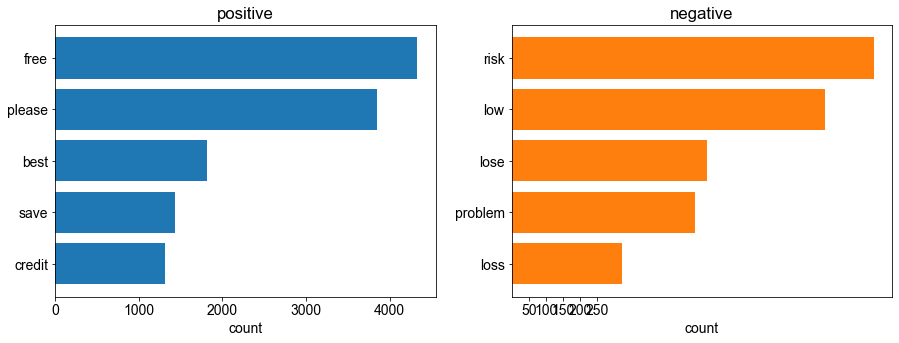

In [ ]:
pos = word_count[word_count['sentiments']=='positive'].sort_values(['size'],ascending=True)
pos = pos[-5:]
neg = word_count[word_count['sentiments']=='negative'].sort_values(['size'],ascending=True)
neg = neg[-5:]
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].barh(pos['word'],
           pos['size'],
           color = colors[0])
ax[0].set_xlabel('count')
ax[0].set_title("positive")

ax[1].xaxis.set_ticks([25,50,75,100,125,150,175]) 
ax[1].barh(neg['word'], 
           neg['size'],
           color = colors[1])
ax[1].set_xlabel('count')
ax[1].set_title("negative")
ax[1].xaxis.set_ticks([50,100,150,200,250])

釣魚信件常用免費、特別等正面字會或危機、問題等誘騙無辜的人上當

#### 第14275封之正負向情緒代表字

In [ ]:
mask = (our_liwc_df['index']==14275) & (~our_liwc_df['sentiments'].isna())
word_count_14275 = our_liwc_df.loc[mask, ['word','sentiments']]
word_count_14275 = word_count_14275.groupby(['word', 'sentiments']).size().reset_index(name='size')
word_count_14275.sort_values('size',ascending=False)

,word,sentiments,size
828,sale,NaN,80
556,letter,NaN,66
737,product,NaN,56
1019,use,NaN,48
768,reader,NaN,42
...,...,...,...
1046,webpageâ,NaN,1
197,constant,NaN,1
886,sitephone,NaN,1
200,contactr,NaN,1


Text(0.5, 0, 'count')

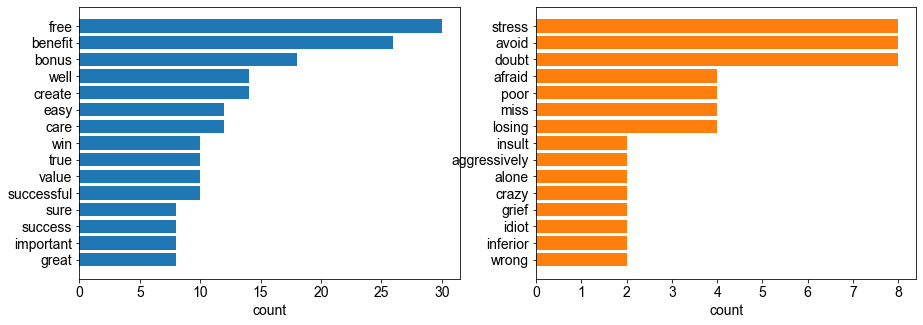

In [ ]:
pos = word_count_14275[word_count_14275['sentiments']=='positive'].sort_values(['size'],ascending=True)
pos = pos[-15:]
neg = word_count_14275[word_count_14275['sentiments']=='negative'].sort_values(['size'],ascending=True)
neg = neg[-15:]
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].barh(pos['word'],
           pos['size'],
           color = colors[0])
ax[0].set_xlabel('count')
ax[1].barh(neg['word'], 
           neg['size'],
           color = colors[1])
ax[1].set_xlabel('count')

在這封釣魚信件中利用免費、特別、贏得等正面字會或壓力、為避免等字彙誘騙使人上當

#### 各封情緒分數

In [ ]:
mask = ~our_liwc_df['sentiments'].isna()
our_sentiment_value = sentiment_count.pivot_table(index='index', columns='sentiments', values='size', fill_value=0).reset_index().rename_axis(None, axis=1)
our_sentiment_value.head()

,index,NaN,affect,anger,anx,negative,positive,sad
0,3,36,7,0,0,0,7,0
1,4,52,6,0,0,3,3,3
2,7,669,23,0,3,7,16,1
3,8,46,6,0,0,2,4,2
4,10,120,13,0,0,0,13,0


In [ ]:
# sentiment 計算方式: positive - anger - anx - negative - sad
our_sentiment_value["sentiment_value"] = (
    our_sentiment_value["positive"]
    - our_sentiment_value["anger"]
    - our_sentiment_value["anx"]
    - our_sentiment_value["negative"]
    - our_sentiment_value["sad"]
)
our_sentiment_value.head()

,index,NaN,affect,anger,anx,negative,positive,sad,sentiment_value
0,3,36,7,0,0,0,7,0,7
1,4,52,6,0,0,3,3,3,-3
2,7,669,23,0,3,7,16,1,5
3,8,46,6,0,0,2,4,2,0
4,10,120,13,0,0,0,13,0,13


Text(0, 0.5, 'sentiment value')

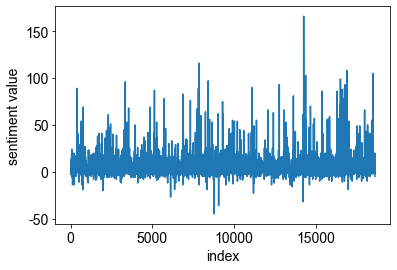

In [ ]:
fig, ax = plt.subplots()
ax.plot(our_sentiment_value['index'], our_sentiment_value["sentiment_value"])
ax.set_xlabel('index')
ax.set_ylabel('sentiment value')

可看出大部分釣魚信件情緒都是正面居多